# <div id="chap1">1. Import libraries

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
# import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.random import shuffle

In [2]:
import yfinance as yf

# <div id="chap2">2. Preprocessing

In [3]:
COMPANY = '^GSPC'


In [4]:
data = yf.download(COMPANY, start='2015-01-01', end='2022-01-01')
len(data)

[*********************100%***********************]  1 of 1 completed


1763

In [5]:
array_data = np.array(data['Close'])
n_data = array_data.size
time_data = np.arange(0, n_data)
Polynomial = np.polyfit(time_data, array_data, 1)
data_notrend = array_data - Polynomial[0] * time_data  # detrended x
data['Close'] = data_notrend

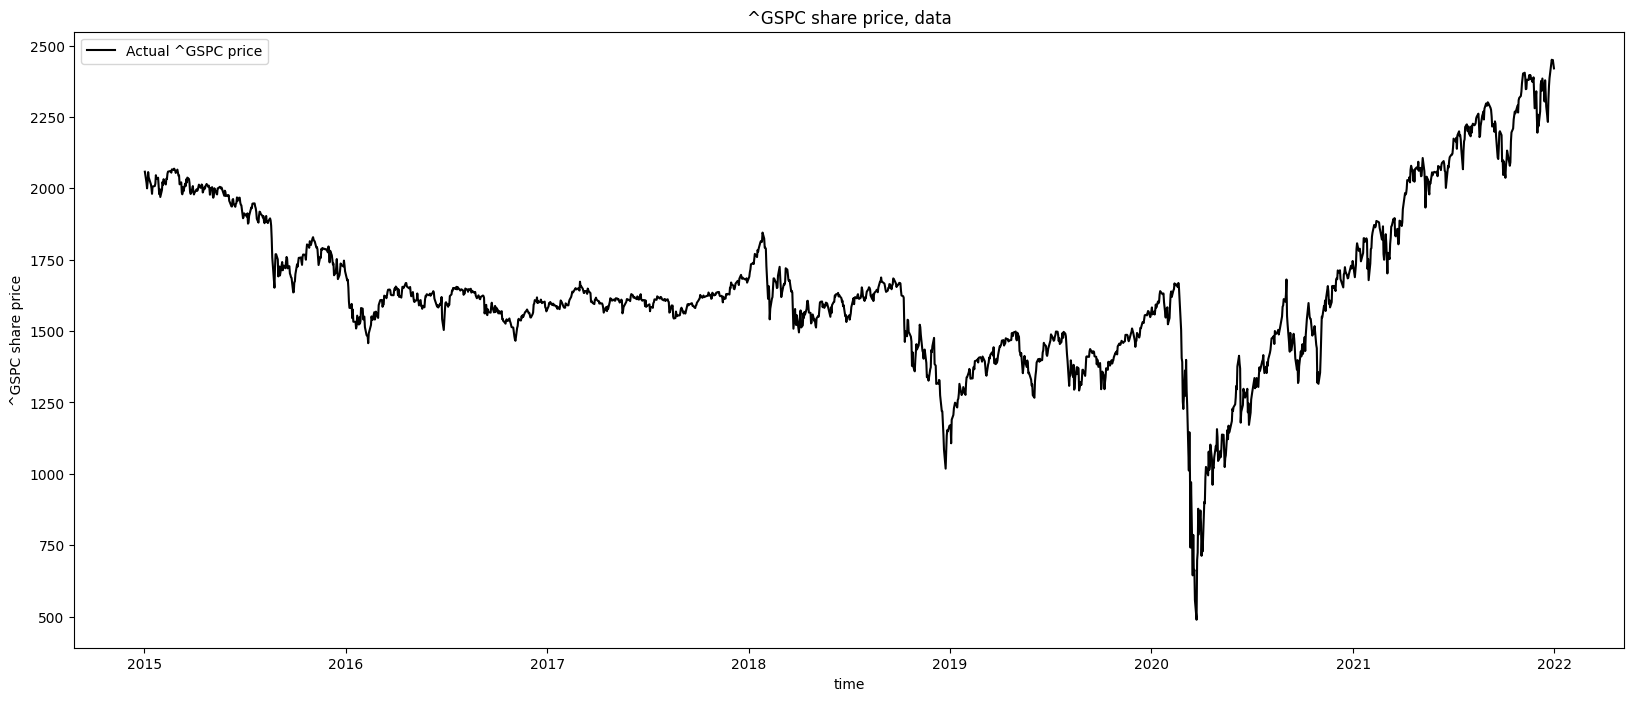

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, data")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [7]:
import math
math.ceil(len(data)*0.8)

1411

In [8]:
train_data = data[0:math.ceil(len(data)*0.8)]
print(len(train_data))
test_data = data[math.ceil(len(data)*0.8):]
print(len(test_data))

1411
352


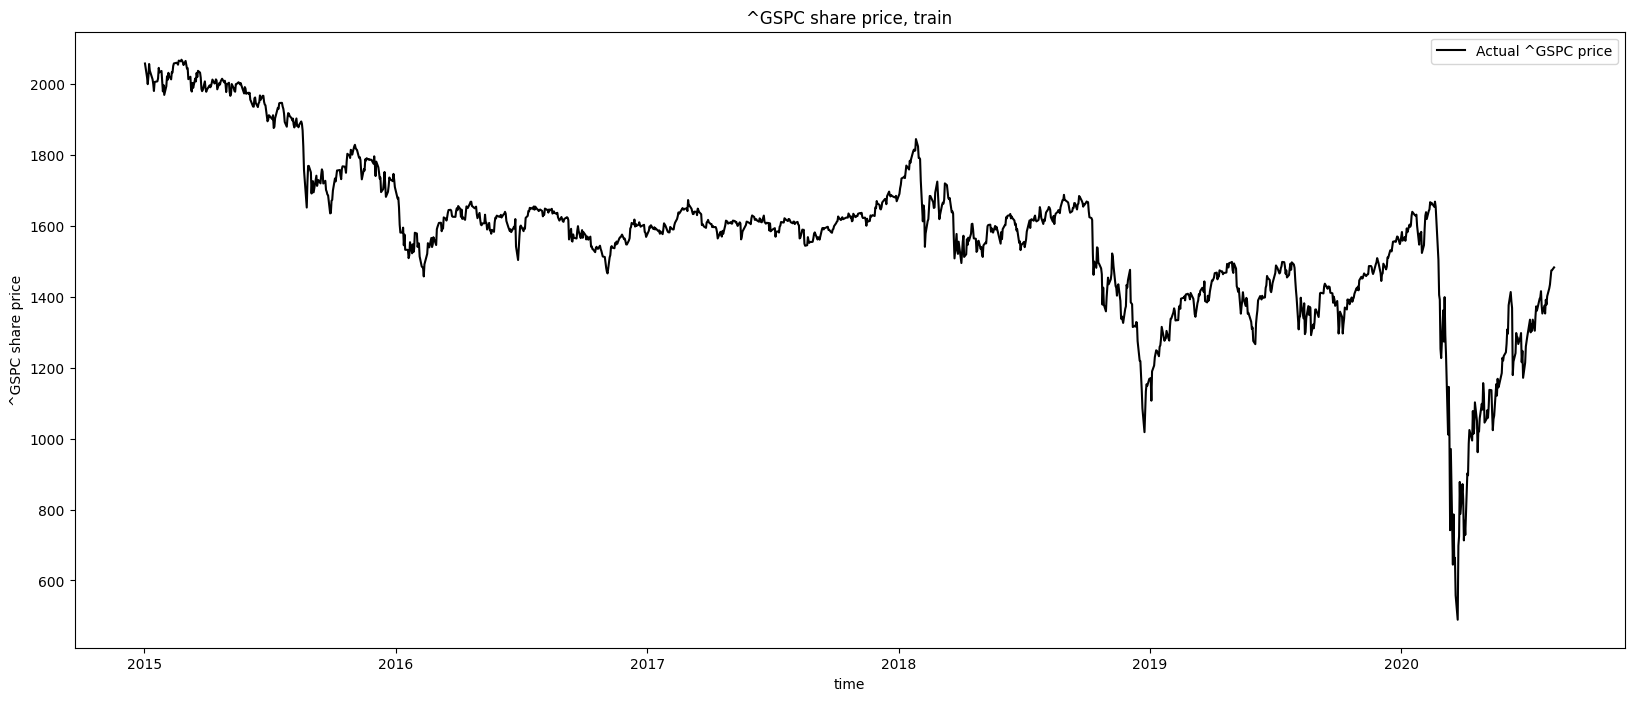

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(train_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, train")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

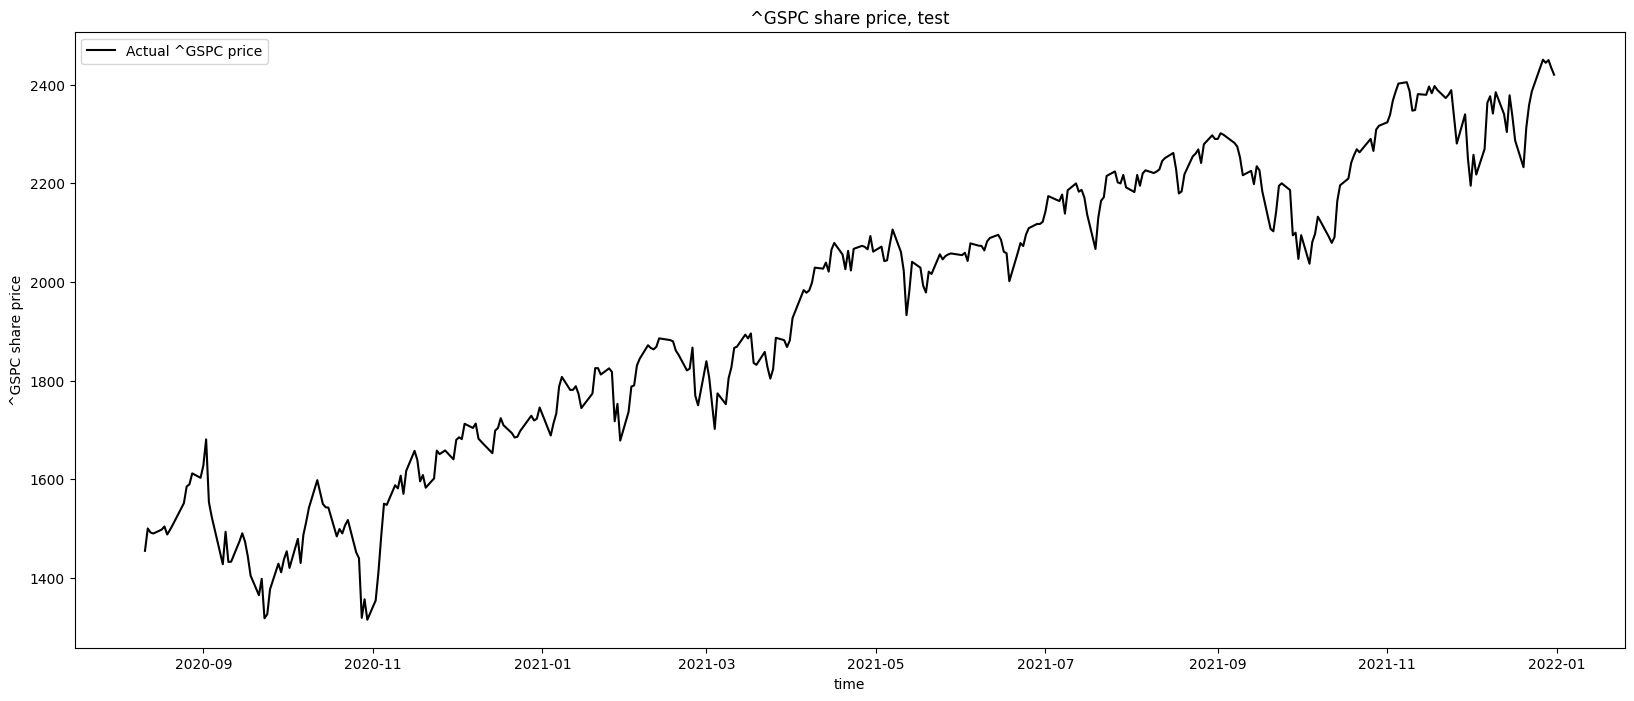

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(test_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, test")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [11]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

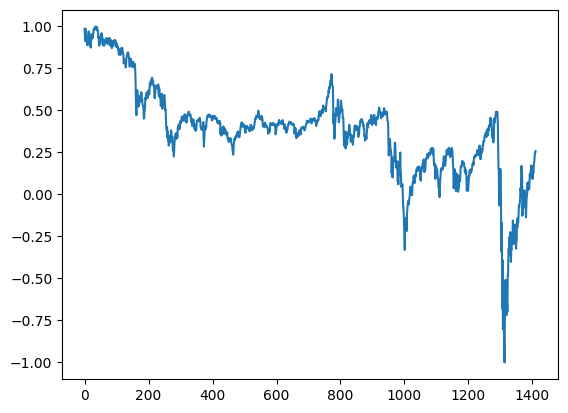

In [12]:
plt.plot(scaled_data)

In [13]:
# how many days do i want to base my predictions on ?
base_day = 30
prediction_day = 30
x_train = []
y_train = []
slide = 5
# 從base_day開始，往前提取base_day天的數據，作為輸入變量x_train，並將當前價格作為輸出變量y_train
for x in range(base_day+prediction_day, len(scaled_data), slide):
    x_train.append(scaled_data[x-base_day-prediction_day:x-prediction_day, 0])
    y_train.append(scaled_data[x-prediction_day:x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [14]:
y_train.shape

(271, 30, 1)

# <div id="chap3">3. Build LSTM model

In [15]:
def LSTM_model(prediction_day):
    
    model = Sequential()
    
    model.add(LSTM(units = 256, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))

    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    
    model.add(Dense(units=prediction_day))
    
    return model

# <div id="chap4">4. Training

In [16]:
# model = LSTM_model()
# model.summary()
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define callbacks
# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
# earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

# history = model.fit(x_train, y_train, epochs=25, batch_size = 32, callbacks = [checkpointer, earlystopper], validation_split = 0.2)

# # plot loss curves
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()


In [17]:
model = LSTM_model(prediction_day)
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 30)                1

In [18]:
# # Define callbacks

# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
#                                verbose = 2, 
#                                save_best_only = True)

# model.fit(x_train, 
#           y_train, 
#           epochs=25, 
#           batch_size = 32,
#           callbacks = [checkpointer])

In [19]:
# Define callbacks
# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 80, verbose = 2)
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks = [checkpointer, earlystopper], validation_split = 0.2, shuffle=True)


Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 0.1664
Epoch 1: val_loss improved from inf to 0.08370, saving model to weights_best.hdf5
7/7 [==============================] - 8s 402ms/step - loss: 0.1664 - val_loss: 0.0837
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 0.0899
Epoch 2: val_loss improved from 0.08370 to 0.08029, saving model to weights_best.hdf5
7/7 [==============================] - 1s 155ms/step - loss: 0.0899 - val_loss: 0.0803
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 0.0681
Epoch 3: val_loss did not improve from 0.08029
7/7 [==============================] - 1s 152ms/step - loss: 0.0681 - val_loss: 0.0810
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 0.0521
Epoch 4: val_loss did not improve from 0.08029
7/7 [==============================] - 1s 155ms/step - loss: 0.0521 - val_loss: 0.0833
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 0.0419
Epoch 5: val_loss im

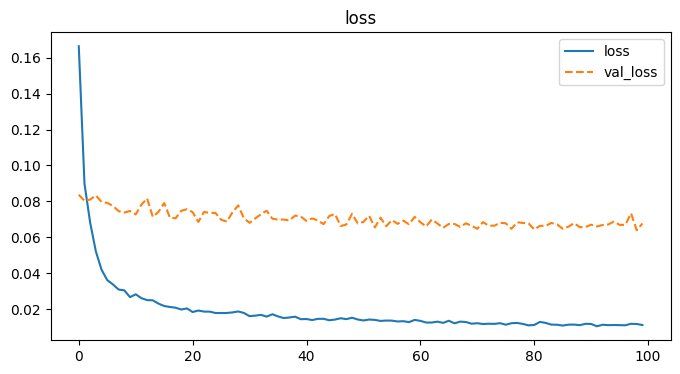

In [20]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()



# <div id="chap5">5. Predictions

In [21]:
# test model accuracy on existing data

actual_prices = test_data['Close'].values
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-base_day:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

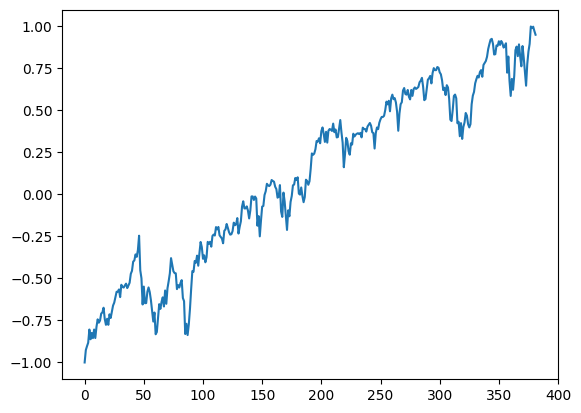

In [22]:
plt.plot(model_inputs)

In [23]:
x_test = []
y_test = []
for x in range(base_day+prediction_day, len(model_inputs), slide):
    x_test.append(model_inputs[x-base_day-prediction_day:x-prediction_day, 0])
    y_test.append(model_inputs[x-prediction_day:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
# predicted_prices = scaler.inverse_transform(predicted_prices)
print(f"predicted_prices: {predicted_prices}")

3/3 [==============================] - 1s 28ms/step
predicted_prices: [[-0.31278068 -0.3917144  -0.29414076 ... -0.15089609 -0.07892741
  -0.13886565]
 [-0.30454177 -0.37933123 -0.28269637 ... -0.15291886 -0.08273564
  -0.13702387]
 [-0.29444718 -0.36690414 -0.27415437 ... -0.15110098 -0.08494316
  -0.13240933]
 ...
 [ 0.73903376  0.73592156  0.7217755  ...  0.67272973  0.6507522
   0.67073846]
 [ 0.86588305  0.8616018   0.84201556 ...  0.7812518   0.7557536
   0.7815272 ]
 [ 0.87401533  0.87091386  0.85622394 ...  0.7918749   0.7678307
   0.7942391 ]]


In [24]:
type(predicted_prices)

numpy.ndarray

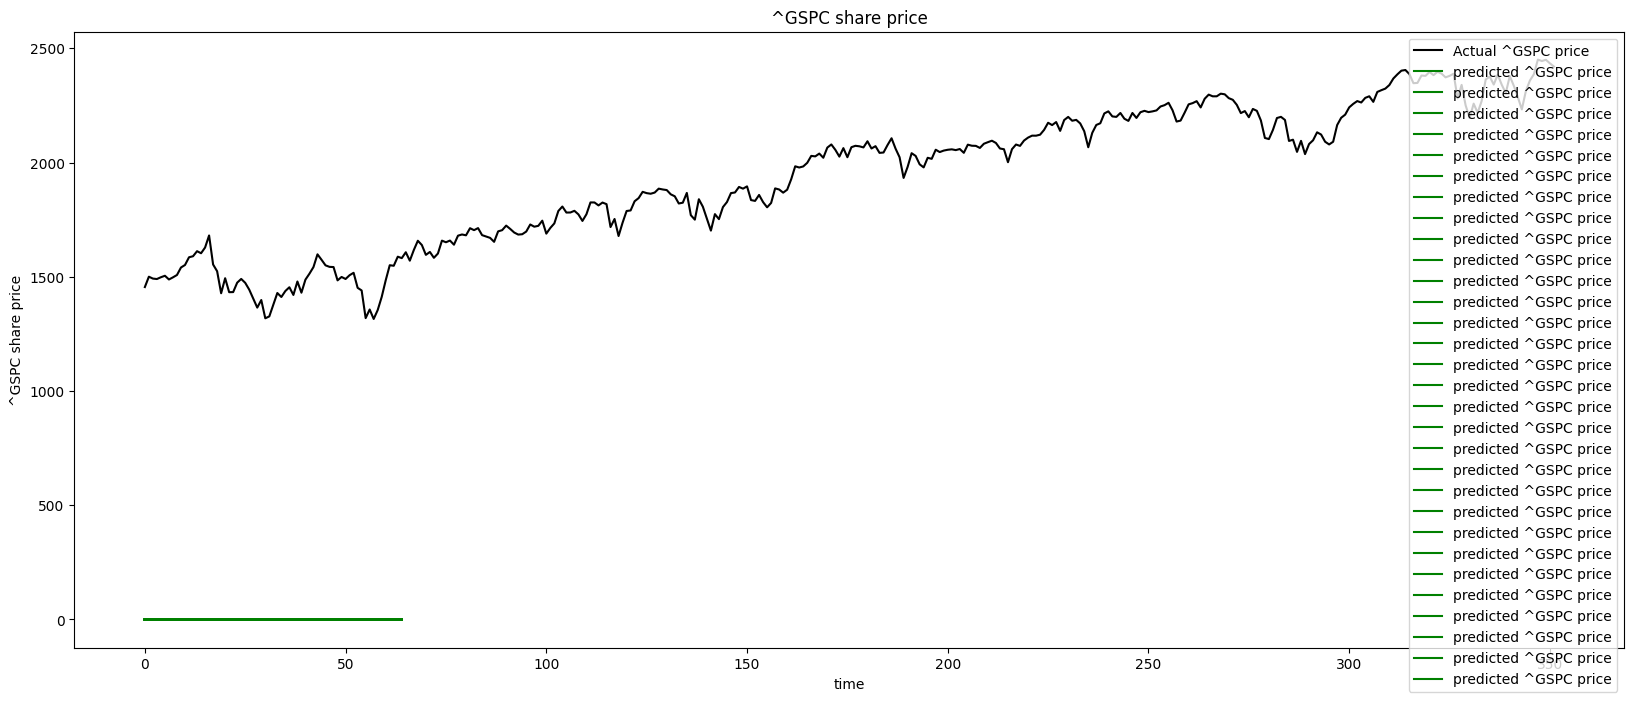

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color='green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

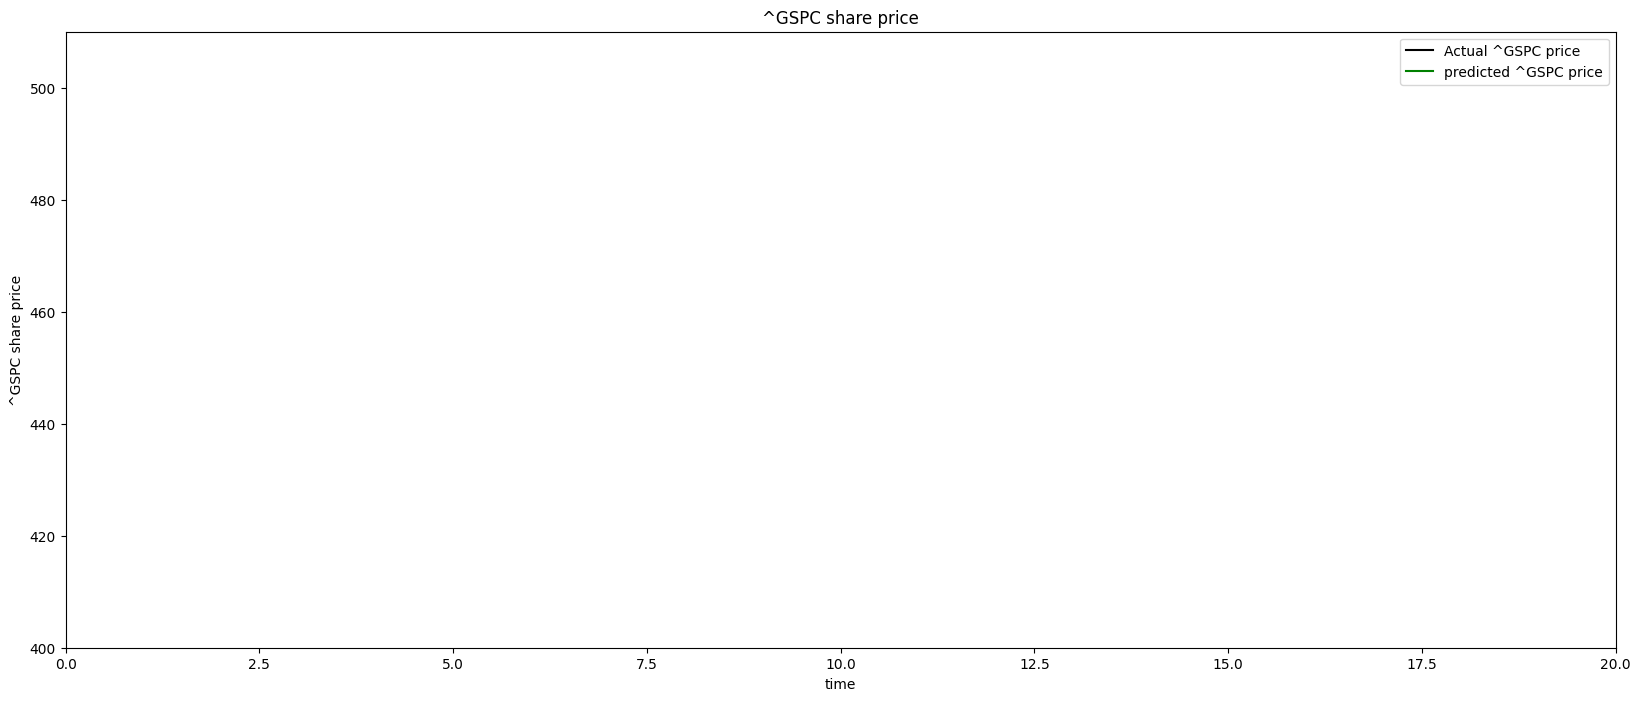

In [26]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices[0], color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.xlim(0, 20)
plt.ylim(400, 510)
plt.legend()
plt.show()

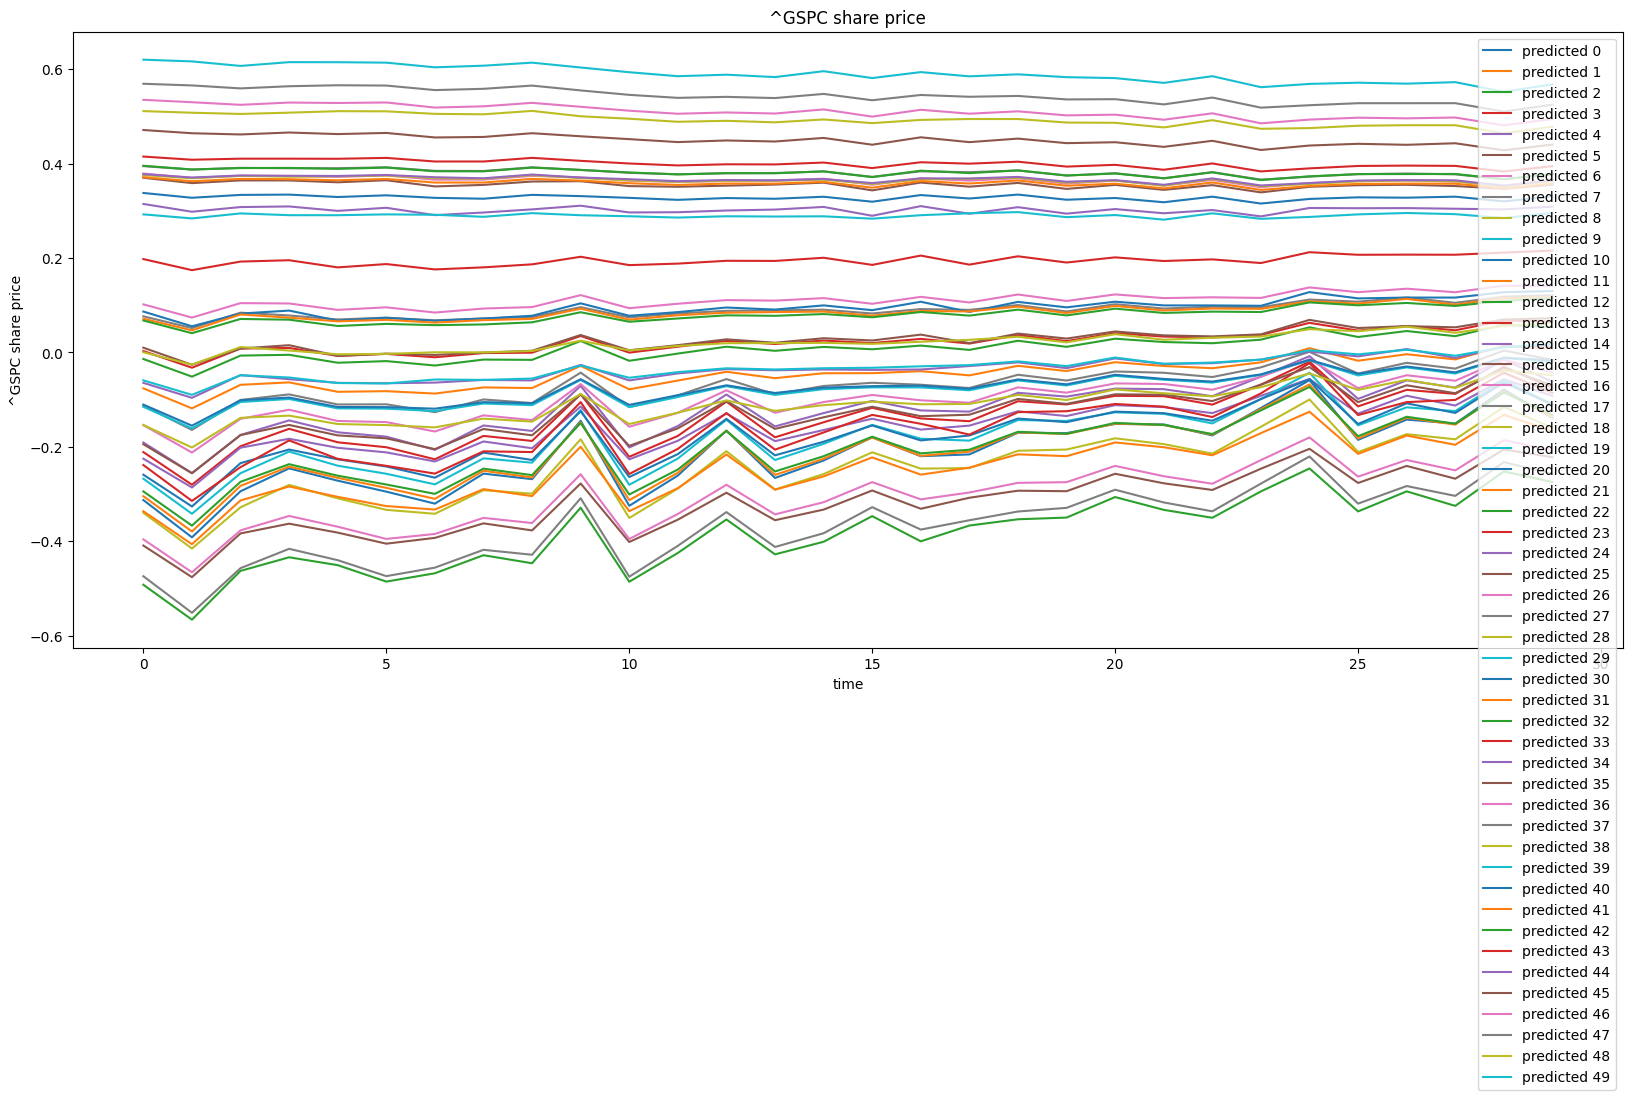

In [27]:
plt.figure(figsize=(20, 8))
for i in range(0, 50):
    plt.plot(predicted_prices[i], label=f"predicted {i}")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
# plt.xlim(0, 9)
# plt.ylim(400, 510)
plt.legend()
plt.show()

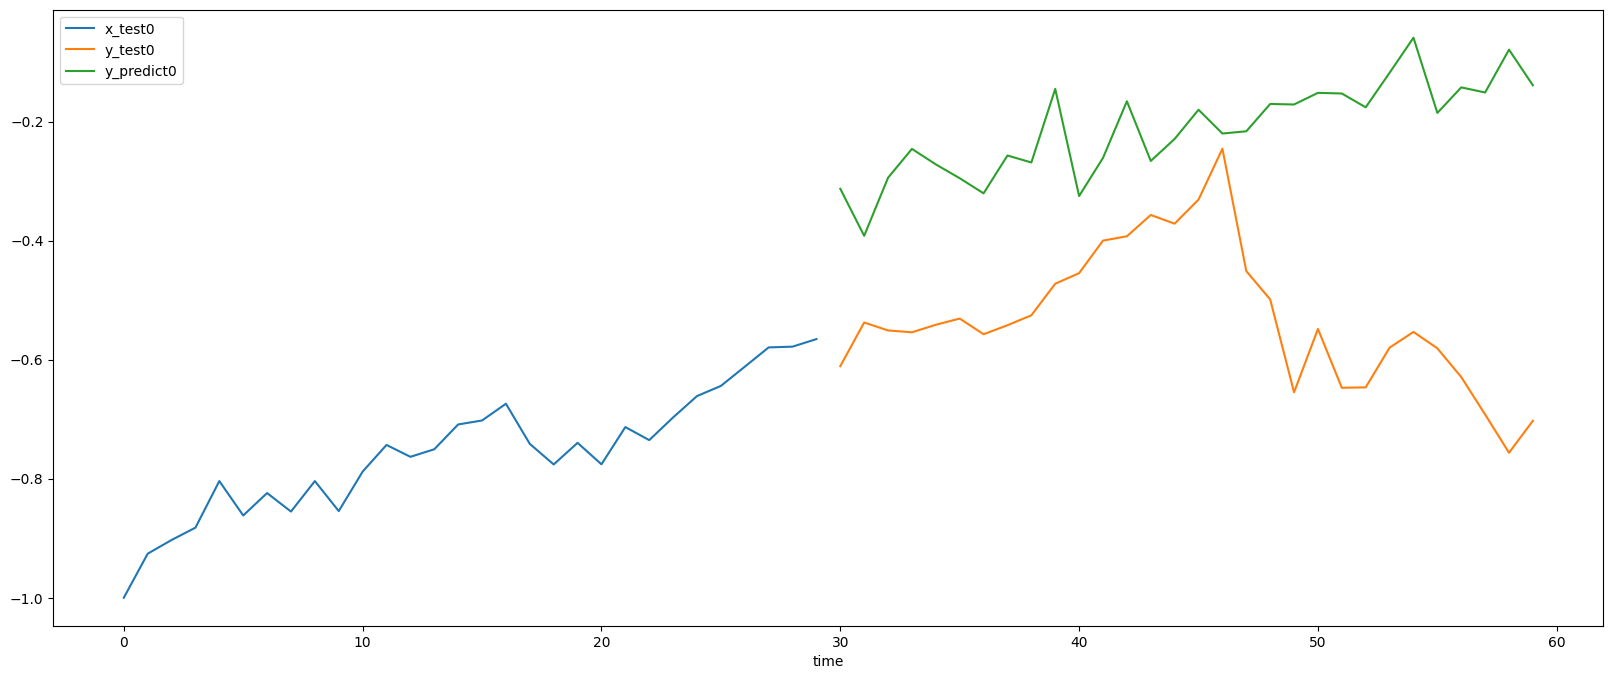

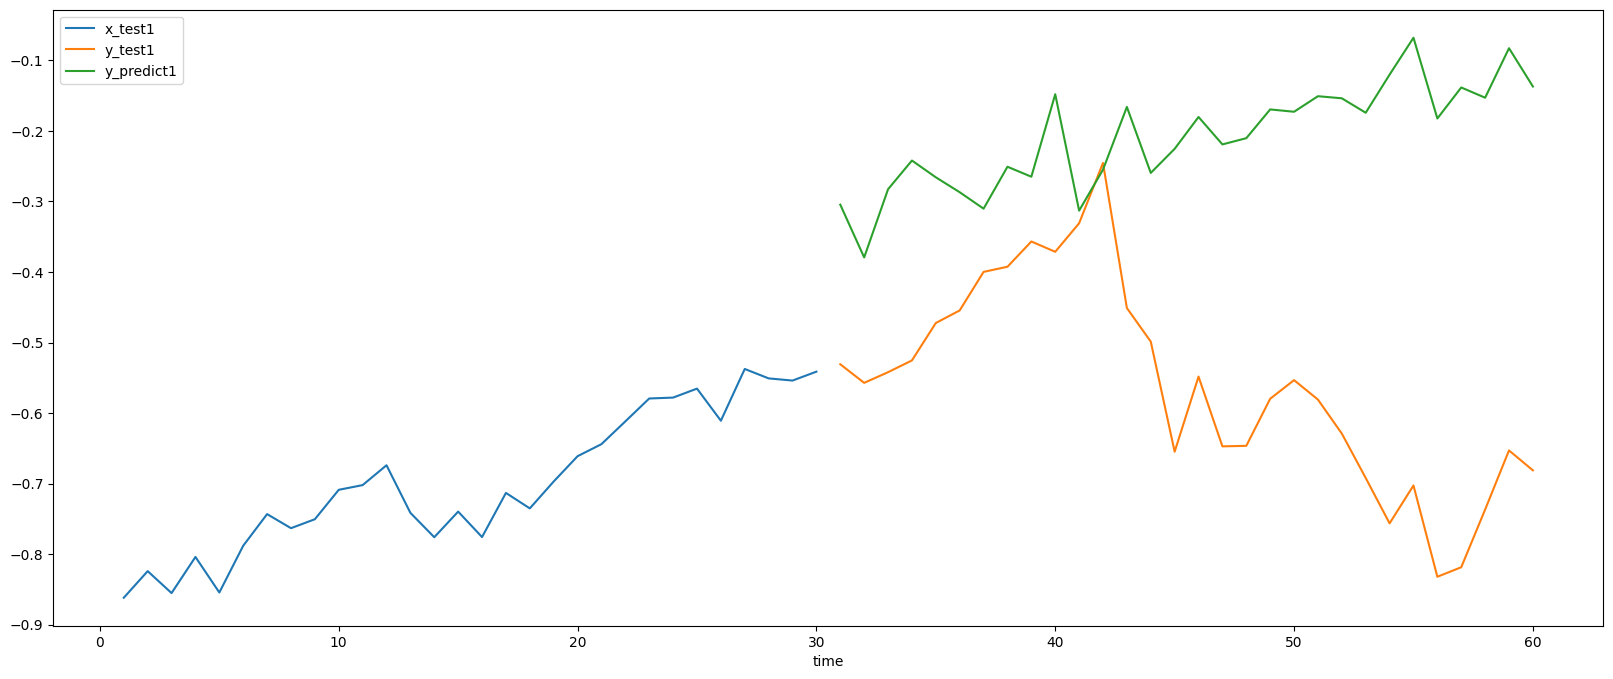

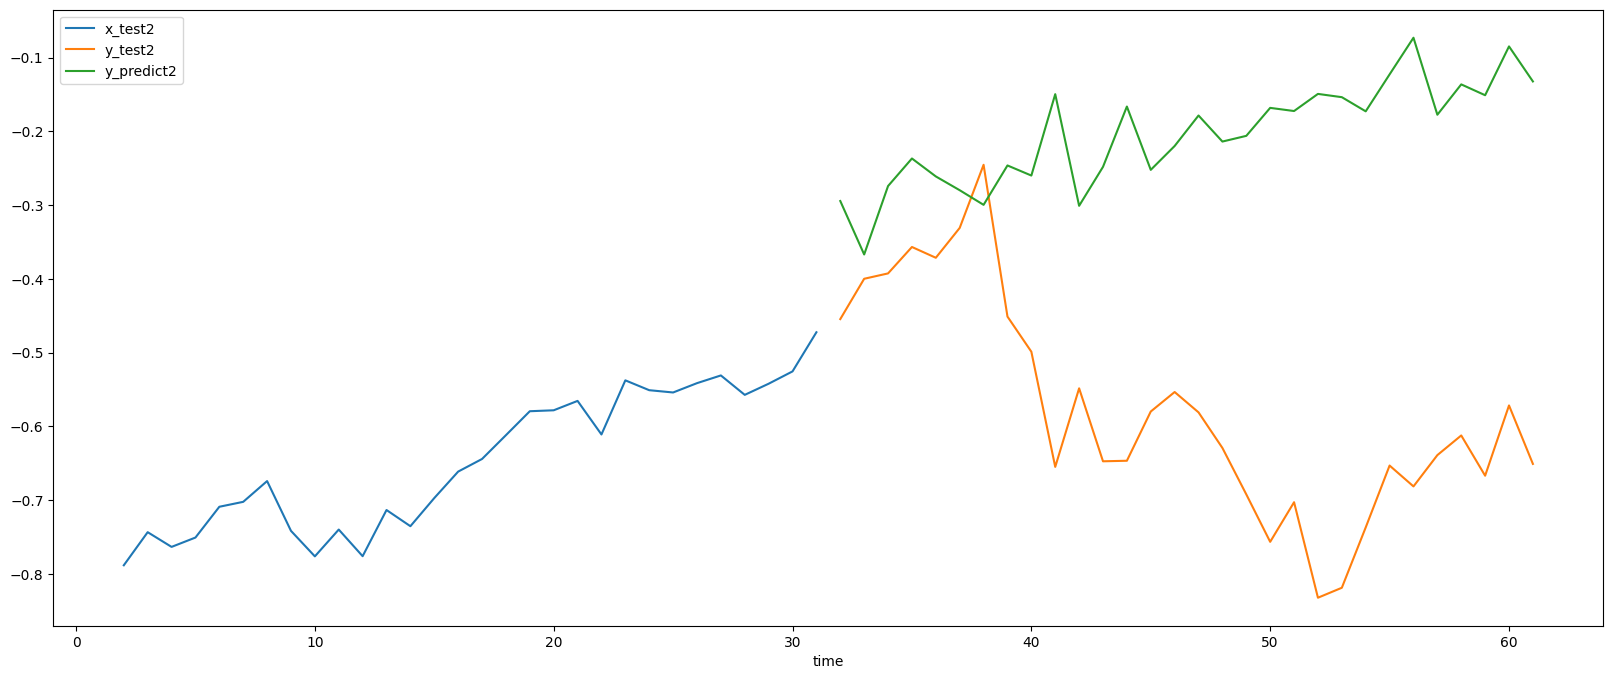

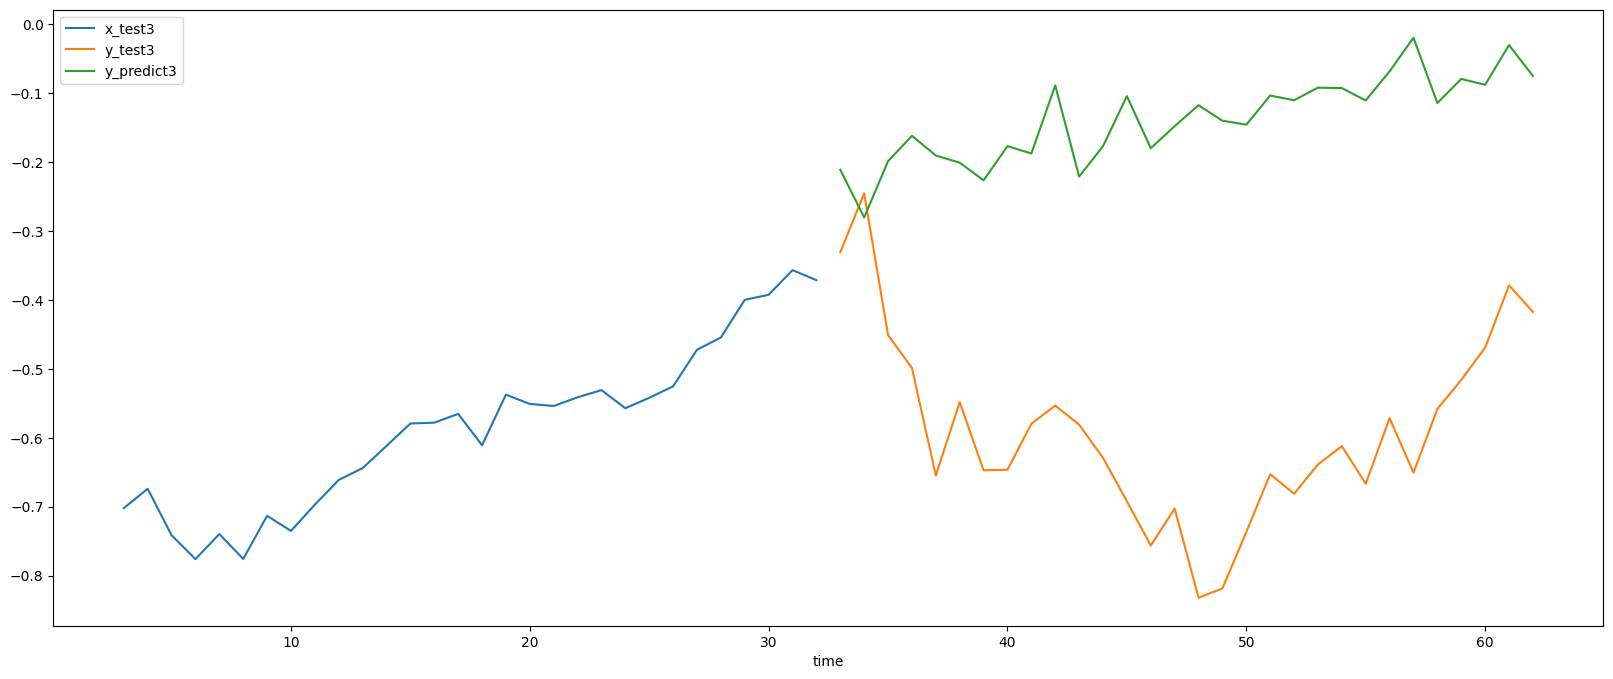

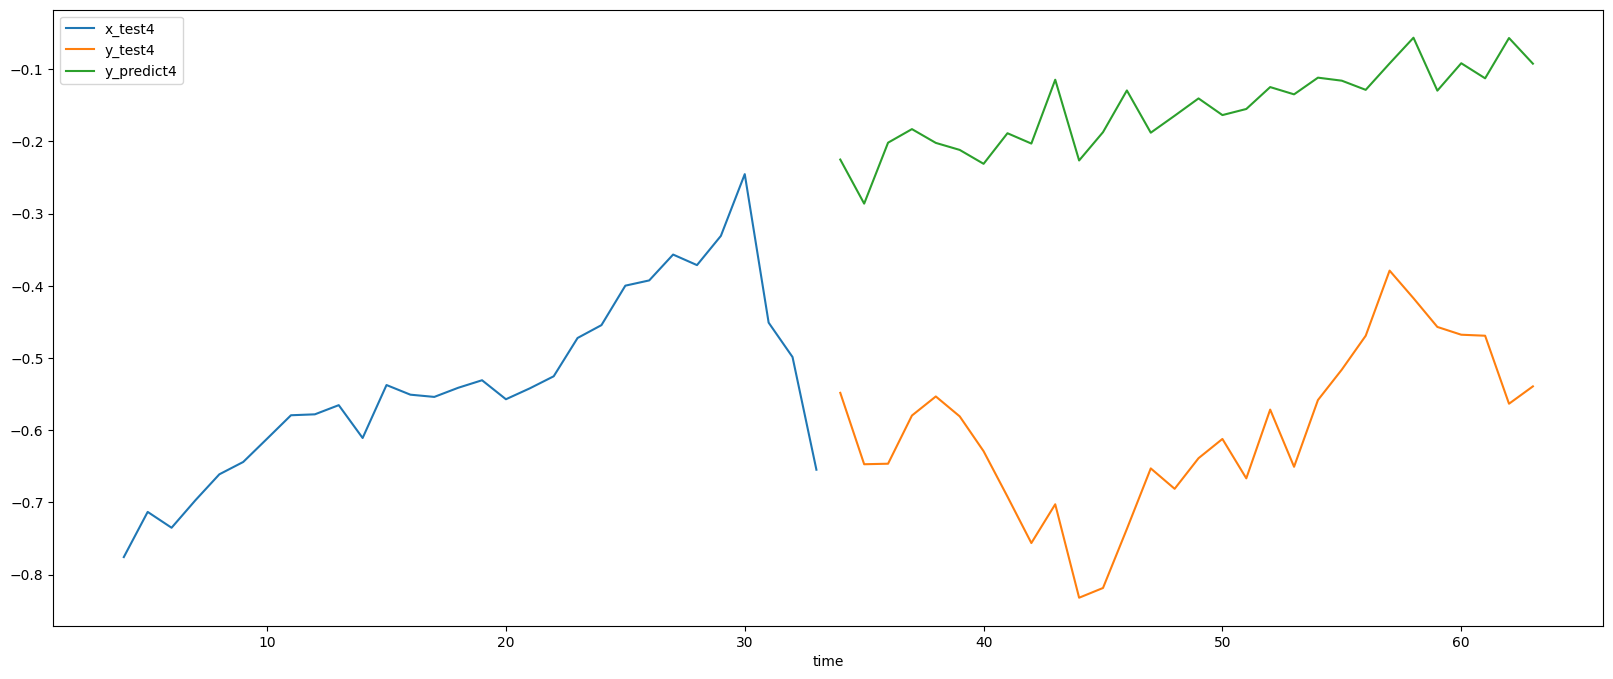

In [28]:
for num in range(0, 5, 1):
    plt.figure(figsize=(20, 8))
    for i in range(num, num+1):
        start = i
        singal = x_test[start]
        plt.plot(range(start,len(singal)+start), singal, label=f"x_test{i}")
    for i in range(num, num+1):
        start = i
        singal = y_test[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_test{i}")
    for i in range(num, num+1):
        start = i
        singal = predicted_prices[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_predict{i}")
    plt.xlabel("time")
    plt.legend()
    plt.show()

In [29]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valley'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valley'


In [30]:
def find_signal_pv_function(signal_souce, pv_range, test_data):
    pd.options.mode.chained_assignment = None
    signal = {}
    for i in range(0, predicted_prices.shape[0]):
        data = pd.Series(signal_souce[i])
        signal[i] = pd.DataFrame()
        signal[i]['Close'] = data
        signal[i].index = test_data.index[range(i, i+predicted_prices.shape[1])]
        signal[i]['peaks'] = pd.Series(dtype='float64')
        signal[i]['valleys'] = pd.Series(dtype='float64')
        signal[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(data)):
            if idx < pv_range and idx>0:
                if data[idx] == data.iloc[0:pv_range*2+1].max():
                    signal[i]['peaks'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[0:pv_range*2+1].min():
                    signal[i]['valleys'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'valley'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                signal[i]['peaks'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'peak'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                signal[i]['valleys'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'valley'
    return signal


In [31]:
pv_range = 2
test_data['Close'] = actual_prices
find_data_pv_CL_function(test_data, pv_range)
processed_signal = find_signal_pv_function(predicted_prices, pv_range, test_data)

C:\Users\e4903\AppData\Local\Temp\ipykernel_14924\1378023055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Close'] = actual_prices


In [32]:
def find_signal_lead_train_function(data, processed_signal):
    for p in processed_signal:
        data = test_data.loc[processed_signal[p].index[0]:processed_signal[p].index[-1]]
        processing_signal = processed_signal[p]
        p_data = pd.DataFrame(
            {'peaks': data['peaks'], 'count': range(len(data))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data['valleys'], 'count': range(len(data))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[p]['lead'] = pd.Series(dtype='float64')
        processed_signal[p]['lead'] = p_signal['lead']
        processed_signal[p]['lead'] = v_signal['lead']


In [33]:
find_signal_lead_train_function(test_data, processed_signal)

In [34]:
def get_first_lead_function(processed_signal):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        temp = processed_signal[i].loc[list(
            processed_signal[i]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [35]:
first_date, lead, pv = get_first_lead_function(processed_signal)

In [36]:
def built_result_table_function(processed_signal, lead, pv):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv'])
    for i in processed_signal:
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
        result_table.loc[i, 's_date'] = processed_signal[i].index[0]
    return result_table


In [37]:
result_table = built_result_table_function(processed_signal, lead, pv)
result_table

,s_date,t_date,lead,ans_date,pv
0,2020-08-11 00:00:00,NaN,-1.0,NaN,valley
1,2020-08-12 00:00:00,NaN,1.0,NaN,valley
2,2020-08-13 00:00:00,NaN,0.0,NaN,valley
3,2020-08-14 00:00:00,NaN,-1.0,NaN,valley
4,2020-08-17 00:00:00,NaN,1.0,NaN,valley
...,...,...,...,...,...
60,2020-11-04 00:00:00,NaN,4.0,NaN,valley
61,2020-11-05 00:00:00,NaN,3.0,NaN,valley
62,2020-11-06 00:00:00,NaN,2.0,NaN,valley
63,2020-11-09 00:00:00,NaN,1.0,NaN,valley


In [38]:
def result_table_process_function(result_table, data, first_date):
    for i in result_table.index:
        t_date = first_date[i]
        result_table.loc[i, 't_date'] = t_date
        ans = data.iloc[int(data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [39]:
result_table_process_function(result_table, test_data, first_date)

In [40]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [41]:
final_error = compute_final_error_function(result_table)

In [42]:
def evaluate_model(processed_signal, test_data, first_date, lead, pv):
    result_table = built_result_table_function(processed_signal, lead, pv)
    result_table_process_function(result_table, test_data, first_date)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error

In [43]:
result_table, final_error = evaluate_model(processed_signal, test_data, first_date, lead, pv)

In [44]:
result_table

,s_date,t_date,lead,ans_date,pv
0,2020-08-11 00:00:00,2020-08-12 00:00:00,-1.0,2020-08-11 00:00:00,valley
1,2020-08-12 00:00:00,2020-08-13 00:00:00,1.0,2020-08-14 00:00:00,valley
2,2020-08-13 00:00:00,2020-08-14 00:00:00,0.0,2020-08-14 00:00:00,valley
3,2020-08-14 00:00:00,2020-08-17 00:00:00,-1.0,2020-08-14 00:00:00,valley
4,2020-08-17 00:00:00,2020-08-18 00:00:00,1.0,2020-08-19 00:00:00,valley
...,...,...,...,...,...
60,2020-11-04 00:00:00,2020-11-06 00:00:00,4.0,2020-11-12 00:00:00,valley
61,2020-11-05 00:00:00,2020-11-09 00:00:00,3.0,2020-11-12 00:00:00,valley
62,2020-11-06 00:00:00,2020-11-10 00:00:00,2.0,2020-11-12 00:00:00,valley
63,2020-11-09 00:00:00,2020-11-11 00:00:00,1.0,2020-11-12 00:00:00,valley


In [45]:
final_error

3.09